In [54]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
np.random.seed(seed=0)

# 1. 실제 수집한 데이터 불러오기

In [55]:
# 버튼&배경 색상표
colors = [[142, 10, 106], [129, 251, 185], [128, 232, 19], [164, 105, 114], [235, 89, 162], [157, 101, 32], [16, 219, 30]]

In [58]:
# 각 버튼 별 좌표 데이터 가져와서 하나의 데이터 프레임으로 합치는 작업
df = pd.DataFrame(columns=['x', 'y', 'label'])

for i, data in enumerate(os.listdir('hand_extract_data')):
    temp = pd.read_csv('hand_extract_data/'+data).astype('int')
    temp['label'] = i
    df = df.append(temp, ignore_index=True)

# 2. 데이터 전처리

In [65]:
# 데이터 0~1로 정규화 작업
df['x'] = (df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min())
df['y'] = (df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min())
df.head()

,x,y,label
0,0.698801,0.101019,0
1,0.904638,0.943466,0
2,0.732152,0.481928,0
3,0.089109,0.457831,0
4,0.197499,0.082484,0


In [66]:
X_data = df.drop(columns=['label']).values
y_data = df['label'].values

In [9]:
# 학습 데이터 전처리
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float64)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float64)

y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float64)

# 3. 학습 모델 생성

In [11]:
model = Sequential([
    InputLayer(input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 231       
Total params: 4,519
Trainable params: 4,519
Non-trainable params: 0
_________________________________________________________________


# 4. 모델 학습

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
ckpt_dir = 'ckpt'
ckpt_path = ckpt_dir+'/keyboard_{epoch}.ckpt'

period = 1

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=1, period=period)

In [15]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, validation_batch_size=128, epochs=500, callbacks=[ckpt_callback])

Epoch 1/500
  1/183 [..............................] - ETA: 1s - loss: 0.1971 - accuracy: 0.9609

183/183 [==============================] - 1s 5ms/step - loss: 0.2565 - accuracy: 0.9057 - val_loss: 0.2453 - val_accuracy: 0.9143

Epoch 00001: saving model to ckpt\keyboard_1.ckpt
Epoch 2/500
183/183 [==============================] - 1s 4ms/step - loss: 0.2436 - accuracy: 0.9124 - val_loss: 0.2369 - val_accuracy: 0.9211

Epoch 00002: saving model to ckpt\keyboard_2.ckpt
Epoch 3/500
183/183 [==============================] - 1s 4ms/step - loss: 0.2368 - accuracy: 0.9161 - val_loss: 0.2341 - val_accuracy: 0.9199

Epoch 00003: saving model to ckpt\keyboard_3.ckpt
Epoch 4/500
183/183 [==============================] - 1s 4ms/step - loss: 0.2287 - accuracy: 0.9174 - val_loss: 0.2228 - val_accuracy: 0.9261

Epoch 00004: saving model to ckpt\keyboard_4.ckpt
Epoch 5/500
183/183 [==============================] - 1s 4ms/step - loss: 0.2225 - accuracy: 0.9214 - val_loss: 0.2139 - val_accuracy: 0.9259

Epoch 00005: saving model to ckpt\keyboard_5.ckpt
Epoch 6/500
183/183 [=====================

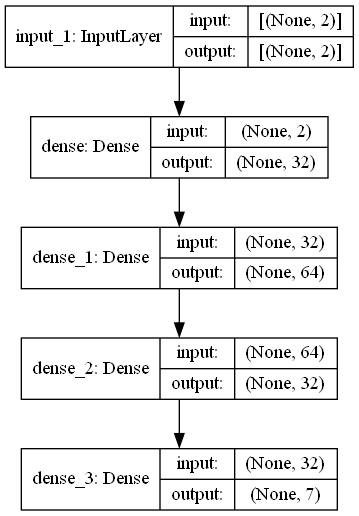

In [44]:
plot_model(model, to_file='model_archtecture.png', show_shapes=True)

# 5. 모델 학습 결과 출력

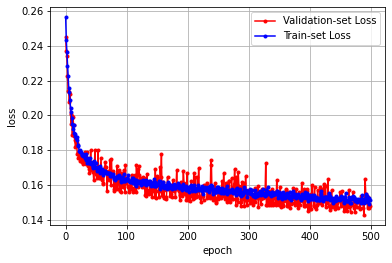

In [16]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

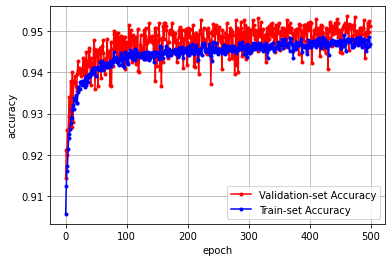

In [17]:
y_vacc = hist.history['val_accuracy']
y_acc = hist.history['accuracy']

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, marker='.', c='red', label="Validation-set Accuracy")
plt.plot(x_len, y_acc, marker='.', c='blue', label="Train-set Accuracy")

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [33]:
model.save("demo_keyboard_model")

INFO:tensorflow:Assets written to: demo_keyboard_model\assets


# 6. 학습한 모델로 가상 인터페이스 생성 테스트

In [ ]:
# 테스트 데이터 생성
test_data = pd.DataFrame(columns=['x','y'])
for x in range(1280):
    for y in range(960):
        temp = pd.DataFrame({'x':[x], 'y':[y]})

        test_data = test_data.append(temp, ignore_index=True)

In [18]:
# 미리 생성한 테스트 데이터 있을 경우 불러올 수 있음
test_data = pd.read_hdf('1280x960.h5', 'df')

c:\Users\KYH\.conda\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


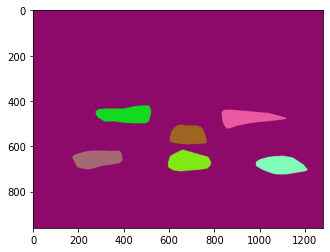

In [19]:
test_input = tf.convert_to_tensor(test_data, dtype=tf.float64)
pred = model.predict_classes(test_input)
pred = tf.reshape(pred, [1280, 960]).numpy()

test = np.full((960, 1280, 3), 255, np.uint8)
for y in range(960):
    for x in range(1280):
        test[y][x] = colors[pred[x][y]]

plt.imshow(test)
plt.show()

In [2]:
model = load_model("demo_keyboard_model")

# 7. Epoch 별 모델이 생성한 가상 인터페이스 결과

epoch : 1


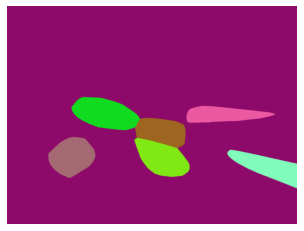

epoch : 10


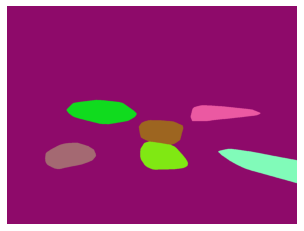

epoch : 20


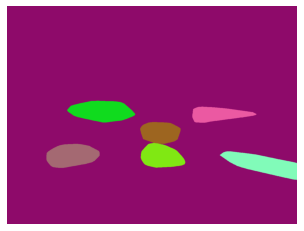

epoch : 30


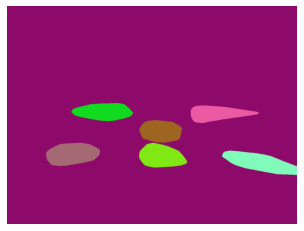

epoch : 40


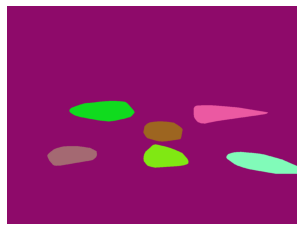

epoch : 50


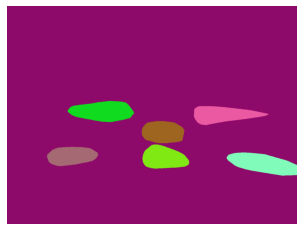

epoch : 100


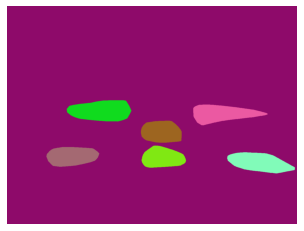

epoch : 200


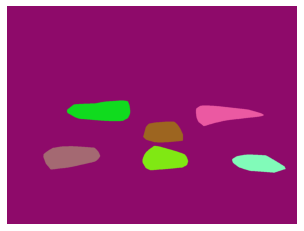

epoch : 300


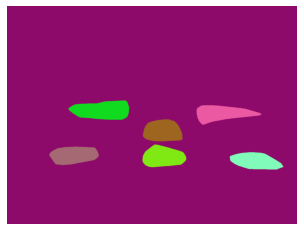

epoch : 400


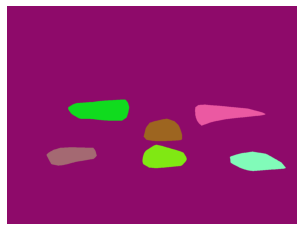

epoch : 500


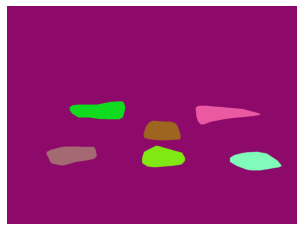

In [20]:
epochs = ['1', '10', '20', '30', '40', '50', '100', '200', '300', '400', '500']
for e in epochs:
    print(f'epoch : {e}')
    model.load_weights(f'ckpt/keyboard_{e}.ckpt')

    test_input = tf.convert_to_tensor(test_data, dtype=tf.float64)
    pred = model.predict_classes(test_input)
    pred = tf.reshape(pred, [1280, 960]).numpy()

    test = np.full((960, 1280, 3), 255, np.uint8)
    for y in range(960):
        for x in range(1280):
            test[y][x] = colors[pred[x][y]]#pred[x][y]
    
    plt.axis('off')
    plt.imshow(test)
    plt.show()

# 8. 모델이 생성한 결과로 가상 인터페이스 버튼 후보정

In [22]:
test_data = pd.read_hdf('1280x960.h5', 'df')
test_input = tf.convert_to_tensor(test_data, dtype=tf.float64)
pred = model.predict_classes(test_input)
pred = tf.reshape(pred, [1280, 960]).numpy()

test = np.full((960, 1280, 3), 255, np.uint8)
for y in range(960):
    for x in range(1280):
        test[y][x] = pred[x][y]

In [31]:
# 0, 1 클래스를 뺀 나머지 인덱스 수 만큼 반복
# 0, 1 클래스는 배경과 라인이기 때문에 제외함
for index in range(1, model.output.shape[1]):
    print(f'min y : {min(np.where(test==index)[0])}')
    print(f'min x : {min(np.where(test==index)[1])}')
    print(f'max y : {max(np.where(test==index)[0])}')
    print(f'max x : {max(np.where(test==index)[1])}')

min y : 642
min x : 984
max y : 723
max x : 1212
min y : 615
min x : 596
max y : 709
max x : 785
min y : 619
min x : 174
max y : 701
max x : 396
min y : 439
min x : 833
max y : 521
max x : 1118
min y : 505
min x : 602
max y : 591
max x : 765
min y : 419
min x : 276
max y : 498
max x : 521


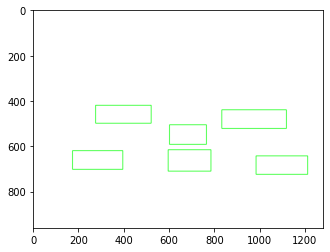

In [32]:
# 0 클래스를 뺀 나머지 인덱스 수 만큼 반복
# 0 클래스는 배경과 라인이기 때문에 제외함
img = np.full((960, 1280, 3), 255, np.uint8)

for index in range(1, model.output.shape[1]):
    min_y = min(np.where(test==index)[0])
    min_x = min(np.where(test==index)[1])
    max_y = max(np.where(test==index)[0])
    max_x = max(np.where(test==index)[1])

    cv2.rectangle(img, (min_x,min_y), (max_x,max_y), (0, 255, 0), thickness=2)

plt.imshow(img)

In [88]:
model = load_model('demo_keyboard_model')

In [34]:
test_data2 = pd.DataFrame(columns=['x','y'])
for x in range(200):
    for y in range(200):
        temp = pd.DataFrame({'x':[x], 'y':[y]})

        test_data2 = test_data2.append(temp, ignore_index=True)

In [35]:
test_data2['x'] = test_data2['x']/200
test_data2['y'] = test_data2['y']/200
test_input2 = tf.convert_to_tensor(test_data2, dtype=tf.float64)
pred2 = model.predict_classes(test_input2)
pred2 = tf.reshape(pred2, [200, 200]).numpy()

c:\Users\KYH\.conda\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
test2 = np.full((200, 200, 3), 255, np.uint8)
for y in range(200):
    print(y)
    for x in range(200):
        test2[y][x] = colors[pred2[x][y]]

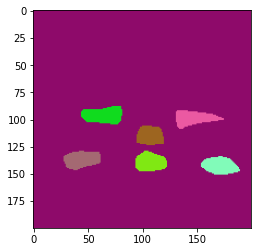

In [50]:
# plt.axis('off')
plt.imshow(test2)

In [38]:
test_data3 = pd.DataFrame(columns=['x','y'])
for x in range(800):
    for y in range(600):
        temp = pd.DataFrame({'x':[x], 'y':[y]})

        test_data3 = test_data3.append(temp, ignore_index=True)

In [39]:
test_data3['x'] = test_data3['x']/800
test_data3['y'] = test_data3['y']/600
test_input3 = tf.convert_to_tensor(test_data3, dtype=tf.float64)

In [40]:
pred3 = model.predict_classes(test_input3)

In [41]:
pred3 = tf.reshape(pred3, [800, 600]).numpy()

In [ ]:
test3 = np.full((600, 800, 3), 255, np.uint8)
for y in range(600):
    print(y)
    for x in range(800):
        test3[y][x] = colors[pred3[x][y]]

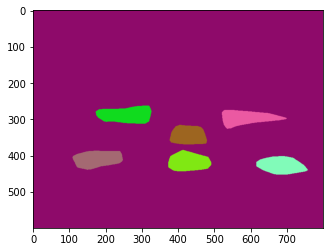

In [51]:
# plt.axis('off')
plt.imshow(test3)